Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import warnings
# import matplotlib.animation
# %matplotlib inline

### Method Set Up

The project description provides the following hint:

<span style="color:red;">

*For numerics, you could use something simple such as forward Euler combined with finite difference, but be sure to validate your choice of step size and other parameters.*

</span>


From this suggestion, we will start exploring the numerical solution with forward Euler.

##### Forward Euler Recap (diffusion only)
$$

U_m^{n + 1} = U_m^{n} + D\Delta t \frac{U_{m+1}^{n} - 2U_m^{n} + U_{m-1}^{n}}{(\Delta x )^2} \\ 

C = \frac{D\Delta t}{(\Delta x )^2} \\ 


U_m^{n + 1} = U_m^{n} + C[{U_{m+1}^{n} - 2U_m^{n} + U_{m-1}^{n}}] \\ 

$$

where $C < 0.5$ for stability.


Rewrite as matrix formulations (from Lecture Notes)

![](docs/forward_euler_matrix_formulation.png)



<!-- $
  \frac{U_m^{n + 1} - U_m^n}{\Delta t} = \frac{U_{m - 1}^n - 2 U_m^n + U_{m + 1}^n}{(\Delta x)^2} \quad \textrm{ for } m \in \left\{ 1, \ldots, M - 1 \right\}, n \in \left\{ 0, \ldots, N - 1 \right\},
$ -->

### Problem Set Up

#### Intravenous Injection

$$

C_t = D C_{xx} - v C_x \\

x \in (-\infty, \infty) \\

D = 0.1 m^2/s \\
v = 0.2 m/s \\

% U_m^{n + 1} = U_m^{n} + D\Delta t \frac{U_{m+1}^{n} - 2U_m^{n} + U_{m-1}^{n}}{(\Delta x )^2} \\ 
$$


#### Boundary Conditions

Infinite boundary conditions
$$
\lim_{x \to \infty} C(x, t) = 0 \\

\lim_{x \to -\infty} C(x, t) = 0 \\
$$


For the purposes of numerical analysis, we can assume that the x domain exists from $-L$ to $L$ and our injection starts at $x = 0$. Where $-L$ and $L$ are sufficiently far away from $x = 0$ to not provide boundary intereference on our region of interest.

We can therefore write the dirichlet conditions as
$$
u(-L, t) = 0 \\
u(L, t) = 0 \\
$$


#### Conditions

##### Starting, $t = 0$

#### Initial Concentration
$$
C(x, 0) = \begin{cases} 
C_0, &  0 \leq x \leq 1 \\
0,  & \text{otherwise}
\end{cases}
$$




##### End

At $t^*=60$ arrive at $h$: 

$60*0.2 = 12m$

Initial medicine is 1m long, therefore total distance to heart starting from $x=0$ is 13m.

Define conditions

In [15]:
D = 0.1 # Diffusion coefficient
v = 0.2 # Blood flow rate

Cf_desired = 1e-3 # Desired final concentrations

Set parameters

In [16]:
# Time parameters
Nt_gaps = 5000    # number of timesteps
T = 60             # final time 
Nt_points = Nt_gaps + 1
t = np.linspace(0.,T,Nt_points)  # times at each time step
dt = t[1] - t[0]


# x parameters
Nx_spaces = 1000;   # number of spaces in x
L = 25; 
Nx_points = Nx_spaces + 1 
x = np.linspace(-L, L, Nx_points)    # mesh points in space
dx = x[1] - x[0]

# Check our conditions
C = D*dt/(dx**2)
A = v*dt/(2*dx)

print(f"Delta x = {round(dx, 4)}\nDelta t = {round(dt, 4)}\nC = {round(C, 4)}\nA = {round(A, 4)}")


if C >= 0.5:
    warnings.warn(f'C is greater than 0.5, C = {round(C,4)}')

if A > 1:
    warnings.warn(f'A is greater than 1, A = {round(A,4)}')

# Boundary conditions
# dirichlet
b0 = 0
bL = 0

Delta x = 0.05
Delta t = 0.012
C = 0.48
A = 0.024


Define initial conditions

In [17]:
def I(x, C0): # initial u(x,0)
    u = np.zeros_like(x)
    
    # where x is between 0 and 1, set to C0
    u[(x >= 0) & (x <= 1)] = C0
    return u

# Initial concentration
C0 = 1e-2

Solve using loops

In [18]:
# # Solve
# Define the numerical solution 
# the first index is space and the second time
U = np.zeros((Nx_points, Nt_points))

# The initial condition
U[:,0] = I(x, C0)

# Enforce the boundary condition
U[0,0]  = b0 
U[-1,0] = bL

# Old/current values
u_old = I(x, C0)

# Initialize new matrix
u = np.zeros(Nx_points)

for n in range(1, Nt_points):
    u[0] = b0
    u[-1] = bL
    
    # apply forward Euler on the internal points, diffusion and advection
    for i in range(1, Nx_points-1):
        u[i] = u_old[i] + C *(u_old[i-1] - 2*u_old[i] + u_old[i+1]) - A*(u_old[i+1] - u_old[i-1])

    # update u_old before next step
    u_old[:] = u
    
    # copy into full storage
    U[:,n] = u;

In [19]:
def concentration_x_plot(x, U, t_str, ax):
    heart_loc = 13
    index_closest = (np.abs(x - heart_loc)).argmin()
    C_heart = U[index_closest]
    # print(index_closest)

    # Clear axes for next iteration of animation loop
    # ax.clear() 
    
    ax.plot(x, U, '.')
    
    ax.set_xlabel('x')
    ax.set_ylabel('concentration')
    ax.set_title(t_str)

    ax.set_xlim([0,15])
    
    ax.axvline(x=heart_loc, color='r', linestyle='--')
    
    ax.axhline(y=C_heart, color='b', linestyle='--', label= f'Cf = {round(C_heart, 4)}')
    ax.text(x=12, y=C_heart, s=f'Cf = {round(C_heart, 4)}', color='b', va='bottom', ha='left')
    # ax.legend()
    

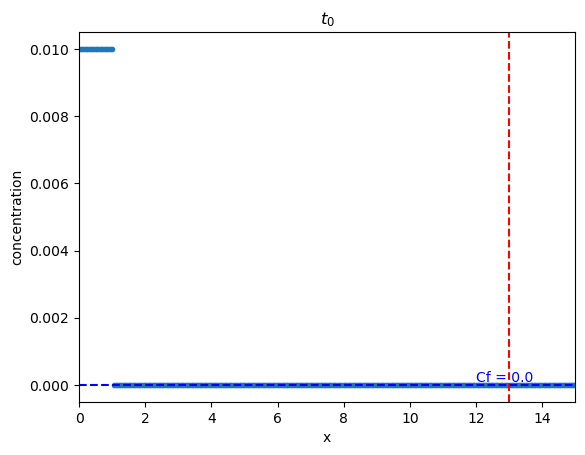

In [20]:
# Plot t = 0 (Initial condition)
fig, ax = plt.subplots()
concentration_x_plot(x, U[:,0], t_str='$t_{0}$', ax=ax)

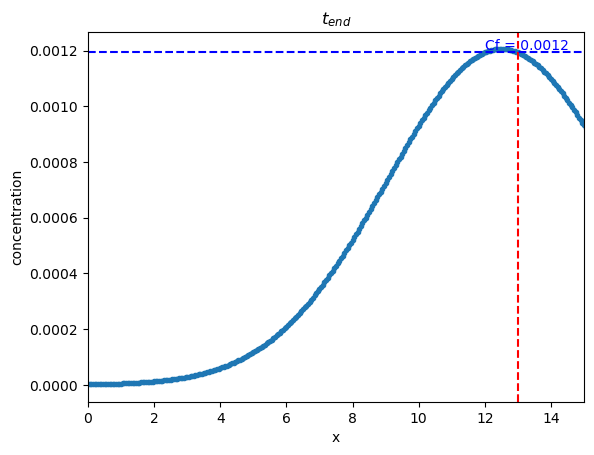

In [21]:
# Plot t = end (End of simulation)
fig, ax = plt.subplots()
concentration_x_plot(x, U[:,-1], t_str='$t_{end}$', ax=ax)

Plot a selected amount of t (t = [0, 5, 10, ..., 60])

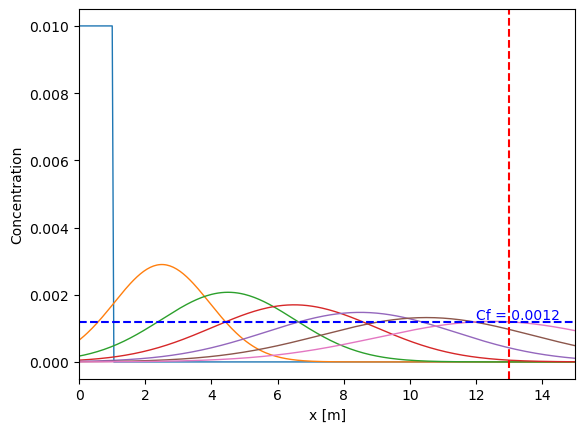

In [22]:
delta_t = 10
t_to_plot = np.arange(0, 60 + delta_t, delta_t)

heart_loc = 13
index_closest = (np.abs(x - heart_loc)).argmin()
C_heart = U[index_closest,-1]


fig, ax = plt.subplots()
for tt in t_to_plot:
    index_closest = (np.abs(t - tt)).argmin()
    ax.plot(x, U[:, index_closest], '-', linewidth = 1)
    
    if tt == 60:
        ax.axhline(y=C_heart, color='b', linestyle='--', label= f'Cf = {round(C_heart, 4)}')
        ax.text(x=12, y=C_heart, s=f'Cf = {round(C_heart, 4)}', color='b', va='bottom', ha='left')
    
ax.set_xlabel('x [m]')
ax.set_ylabel('Concentration')
ax.set_xlim([0,15])

ax.axvline(x=heart_loc, color='r', linestyle='--')

plt.show()

Animation

In [23]:
import matplotlib.animation
%matplotlib inline
from matplotlib.animation import FuncAnimation

def animate(tt):
    concentration_x_plot(x, U[:, tt], t_str=f'$t_{tt}$', ax=ax)

In [24]:
# Set up the figure and axis for the animation
# fig, ax = plt.subplots()

# # Create the animation, calling `animate` at each frame
# ani = FuncAnimation(fig, animate, frames=Nt_points, interval=200)  # interval is in milliseconds

# # Show the animation
# # plt.show()

# from IPython.display import HTML
# HTML(ani.to_jshtml())       

What is the final concentration, $C_f$, at the heart ($x = 13$)?

In [25]:
# Do this in case it happened to not go through x = 13 exactly
index_closest = (np.abs(x - 13)).argmin()

Cf = U[index_closest, -1]

print(f'Cf = {Cf}')

Cf = 0.0011936903323755265


Plot the results as a 3D surface

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5001, 1001) and arg 2 with shape (1001, 5001).

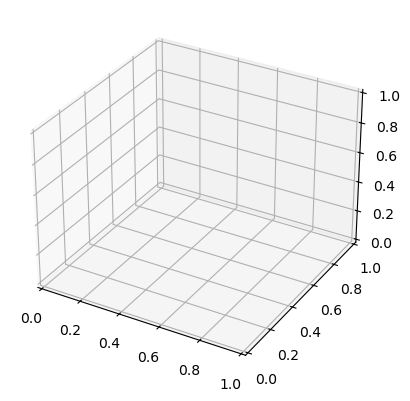

In [26]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, T = np.meshgrid(x, t)

ax.plot_surface(X, T, U, cmap='viridis')
ax.set_xlabel('Position (x) [m]')
ax.set_ylabel('Time [s]')
ax.set_zlabel('Concentration (u)')

# Fix the x lim to the region 

ax.set_title('Concentration')

plt.show()

In [ ]:
t

In [ ]:
import plotly.graph_objs as go
import plotly.express as px

# Create 3D plot
fig = go.Figure(data=[go.Surface(z=U, x=x, y=t, colorscale='Viridis')])

# Update plot layout
fig.update_layout(
    scene = dict(
        xaxis_title='Position (x)',
        yaxis_title='Time (t)',
        zaxis_title='Concentration (u)'
    )
)

fig.show()

### Forward Euler with Matrices

In [8]:
# # Set parameters
# Nt_gaps = 30000    # number of timesteps
# T = 12             # final time 
# Nt_points = Nt_gaps + 1
# t = np.linspace(0.,T,Nt_points)  # times at each time step

# Nx_spaces = 100;   # number of spaces in x
# L = 1; 
# Nx_points = Nx_spaces + 1 
# x = np.linspace(0, L, Nx_points)    # mesh points in space

# dx = x[1] - x[0] 
# dt = t[1] - t[0]

# # Check our conditions
# C = D*dt/(dx**2)
# A = v*dt/(2*dx)

# print("Delta x =", dx, "Delta t = ", dt, "C =", C, "A=", A)

In [9]:
# # set up matrices for single time solutions and the full solution
# u   = np.zeros(Nx_points)
# u_old = np.zeros(Nx_points)

# U = np.zeros((Nx_points,Nt_points))

# # Data structures for the linear system
# A = np.zeros((Nx_points, Nx_points))
# for i in range(1, Nx_points-1):
#     A[i,i-1] = C - A
#     A[i,i+1] = C + A
#     A[i,i] = 1 - 2*C



# # implement the (constant-in-time) Dirichlet conditions
# A[0,0] = 1
# A[Nx_points-1,Nx_points-1] = 1

Code the analytical solution for comparison purposes

### Backwards Euler